In [1]:
import os
import glob
import random
import time

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.models import *

Using TensorFlow backend.


In [2]:
def testGenerator(test_path, filenames):
    for file in filenames:
        #idx = str(i+1).zfill(5) + ".png"
        img = cv2.imread(os.path.join(test_path, file), 0)
        img = img / 255
        img = np.reshape(img, img.shape + (1,))
        img = np.reshape(img,(1,)+img.shape)
        yield img

In [3]:
def saveResult(save_path, files):
    for i, item in enumerate(files):
        img = item[:,:,0]
        idx = str(i+1).zfill(5) + ".png"
        cv2.imwrite(os.path.join(save_path, idx), img)

#### Load the trained model

In [4]:
trained_model = load_model("lung_segmentation_64.hdf5")

In [5]:
trained_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 64)   36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 64)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

#### Test with some random patches

In [21]:
test_dir = "data_64/test/cxr_patches"
files = os.listdir(test_dir)
random_files = random.sample(files, 20)
test_data = testGenerator(test_dir, random_files)

In [22]:
results = trained_model.predict_generator(test_data, 20, verbose=1)

20/20 [==============================] - 0s 14ms/step


Original patches Ground Truth    Prediction


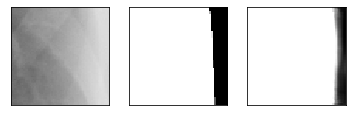

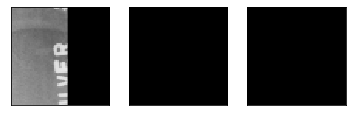

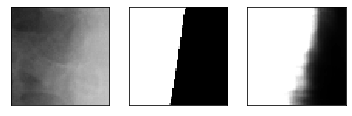

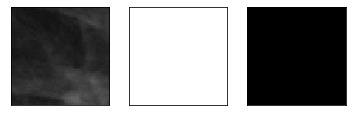

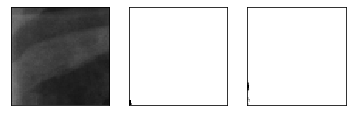

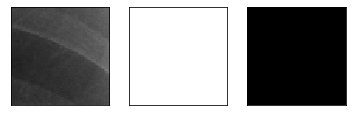

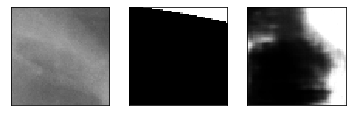

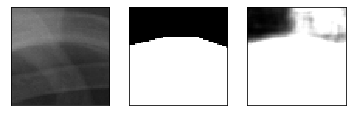

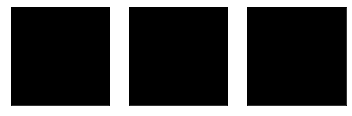

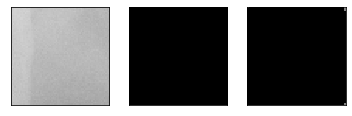

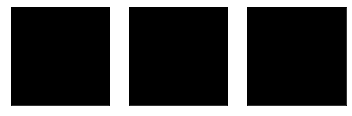

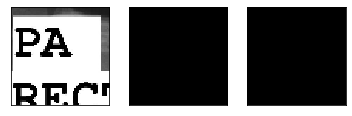

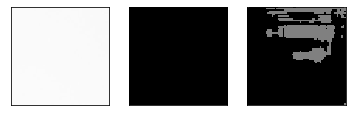

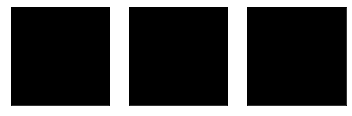

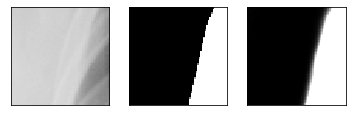

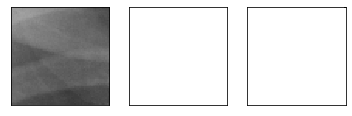

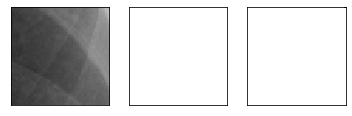

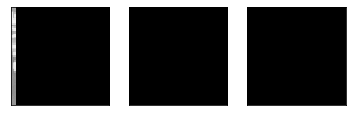

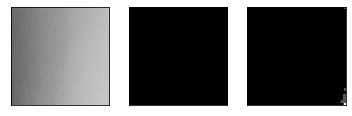

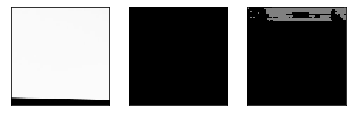

In [23]:
print("Original patches Ground Truth    Prediction")
for i, file in enumerate(random_files):
    cxr_img_actual = cv2.imread(os.path.join("data_64/test/cxr_patches",file))
    cxr_mask_gt = cv2.imread(os.path.join("data_64/test/mask_patches",file))
    cxr_mask_predicted = (np.resize(results[i, :,:], (64, 64))*255).astype(np.uint8)

    f, axarr = plt.subplots(1, 3)
    axarr[0].imshow(cxr_img_actual, cmap='gray')
    axarr[0].set_xticks([]), axarr[0].set_yticks([]) 
    
    axarr[1].imshow(cxr_mask_gt, cmap='gray')
    axarr[1].set_xticks([]), axarr[1].set_yticks([]) 
    
    axarr[2].imshow(cxr_mask_predicted, cmap='gray')
    axarr[2].set_xticks([]), axarr[2].set_yticks([]) 
        
plt.show()

In [6]:
test_dir = "data_64/val" 
cxr_test_dir = os.path.join(test_dir, "cxr")
mask_test_dir = os.path.join(test_dir, "mask")

Original images   Prediction    Ground Truth


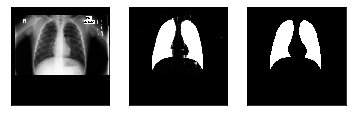

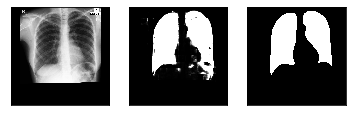

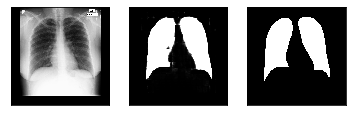

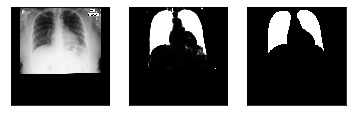

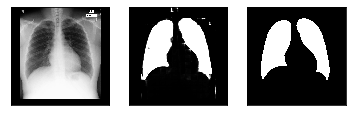

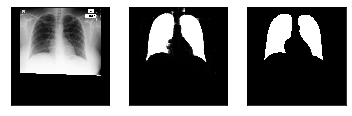

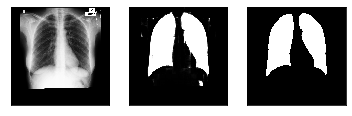

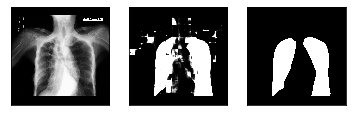

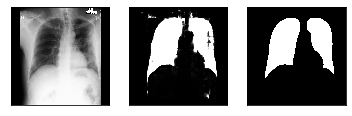

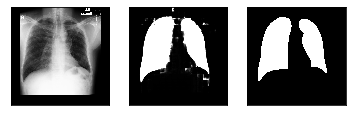

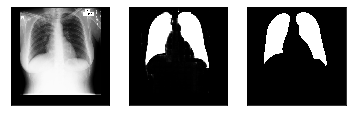

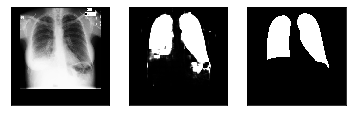

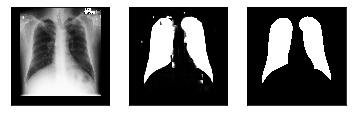

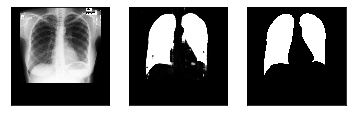

Average execution time:  1.1758240461349487


In [7]:
print("Original images   Prediction    Ground Truth")

#f = "MCUCXR_0001_0.png"
output_dir = os.path.join(test_dir, "outputs")
#output_dir = "data_64/test/outputs"
total_time = 0
for file in os.listdir(cxr_test_dir):
    img = cv2.imread(os.path.join(cxr_test_dir, file), 0)/255
    mask = cv2.imread(os.path.join(mask_test_dir, file))
    predicted_mask = np.zeros(img.shape, dtype=np.uint8)

    start_time = time.time()
    for x in np.arange(0, 1024-64, 64):
        for y in np.arange(0, 1024-64, 64):
            # Crop 64 X 64 cxr and mask patches
            cxr_patch = img[x:x+64, y:y+64]
            cxr_patch = np.reshape(cxr_patch, cxr_patch.shape + (1,))
            cxr_patch = np.reshape(cxr_patch,(1,)+cxr_patch.shape)

            predicted_mask_patch = trained_model.predict(cxr_patch)
            predicted_mask_patch = (np.reshape(predicted_mask_patch, (64, 64))*255).astype(np.uint8)

            predicted_mask[x:x+64, y:y+64] = predicted_mask_patch

    elapsed_time = time.time() - start_time
    
    total_time = total_time+elapsed_time
    
    cv2.imwrite(os.path.join(output_dir, file), predicted_mask)
    
    f, axarr = plt.subplots(1, 3)
    axarr[0].imshow(img, cmap='gray')
    axarr[0].set_xticks([]), axarr[0].set_yticks([]) 
    
    axarr[1].imshow(predicted_mask, cmap='gray')
    axarr[1].set_xticks([]), axarr[1].set_yticks([]) 
    
    axarr[2].imshow(mask, cmap='gray')
    axarr[2].set_xticks([]), axarr[2].set_yticks([]) 
    
plt.show()  

print("Average execution time: ", (total_time/len(os.listdir(cxr_test_dir))))

#### Segment any specific cxr image 

In [35]:
img_dir = "data_64/val"
cxr_img_dir = os.path.join(img_dir, "cxr")
mask_img_dir = os.path.join(img_dir, "mask")

Original images   Prediction    Ground Truth


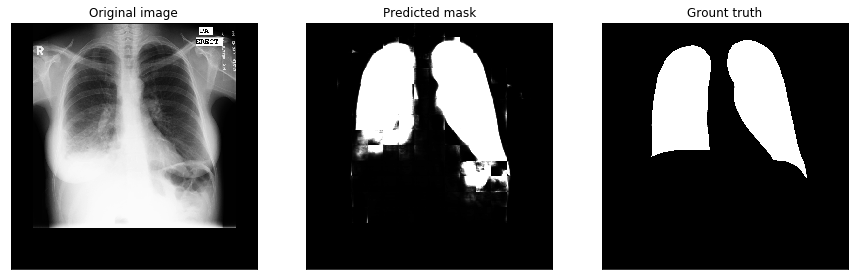

Execution time:  0.8121135234832764


In [38]:
print("Original images   Prediction    Ground Truth")

file = "MCUCXR_0372_1.png"
output_dir = "data_64/val/outputs"
total_time = 0

img = cv2.imread(os.path.join(cxr_img_dir, file), 0)/255
mask = cv2.imread(os.path.join(mask_img_dir, file))
predicted_mask = np.zeros(img.shape, dtype=np.uint8)

start_time = time.time()
for x in np.arange(0, 1024-64, 64):
    for y in np.arange(0, 1024-64, 64):
        # Crop 64 X 64 cxr and mask patches
        cxr_patch = img[x:x+64, y:y+64]
        cxr_patch = np.reshape(cxr_patch, cxr_patch.shape + (1,))
        cxr_patch = np.reshape(cxr_patch,(1,)+cxr_patch.shape)

        predicted_mask_patch = trained_model.predict(cxr_patch)
        predicted_mask_patch = (np.reshape(predicted_mask_patch, (64, 64))*255).astype(np.uint8)

        predicted_mask[x:x+64, y:y+64] = predicted_mask_patch

elapsed_time = time.time() - start_time

total_time = total_time+elapsed_time

cv2.imwrite(os.path.join(output_dir, file), predicted_mask)

titles = ['Original image', 'Predicted mask', 'Grount truth']
images = [img, predicted_mask, mask]

plt.figure(figsize=(15,10))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
    
plt.show()  

print("Execution time: ", elapsed_time)

#### Test with other cxr images
These images are not from the montgomery datasets and don't have the ground truth

In [39]:
img_dir = "others/cxr"

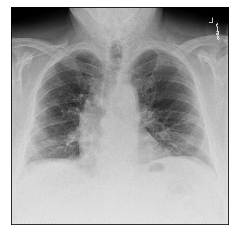

In [73]:
file = "image02.jpg"
img = cv2.imread(os.path.join(img_dir, file), 0)/255

plt.imshow(img,'gray')
plt.xticks([]),plt.yticks([])
plt.show()

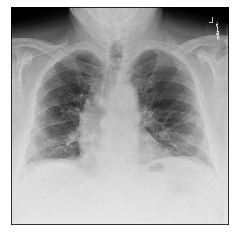

In [74]:
h, w = img.shape
img_size = np.max([h, w])

xx = (img_size - w) // 2
yy = (img_size - h) // 2

scaled_img = np.zeros((img_size, img_size))
scaled_img[yy:yy+h, xx:xx+w] = img
resized_img = cv2.resize(scaled_img, (1024, 1024))

plt.imshow(resized_img,'gray')
plt.xticks([]),plt.yticks([])
plt.show()

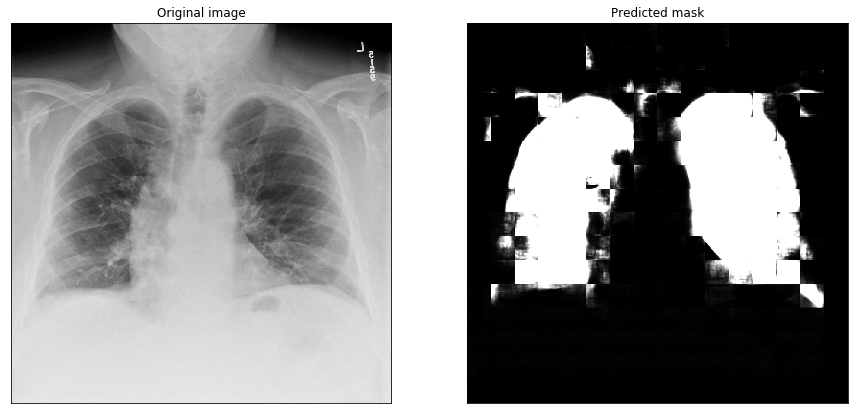

Execution time:  0.8279037475585938


In [75]:
output_dir = "others/outputs"
total_time = 0

predicted_mask = np.zeros(resized_img.shape, dtype=np.uint8)

start_time = time.time()
for x in np.arange(0, 1024-64, 64):
    for y in np.arange(0, 1024-64, 64):
        # Crop 64 X 64 cxr and mask patches
        cxr_patch = resized_img[x:x+64, y:y+64]
        cxr_patch = np.reshape(cxr_patch, cxr_patch.shape + (1,))
        cxr_patch = np.reshape(cxr_patch,(1,)+cxr_patch.shape)

        predicted_mask_patch = trained_model.predict(cxr_patch)
        predicted_mask_patch = (np.reshape(predicted_mask_patch, (64, 64))*255).astype(np.uint8)

        predicted_mask[x:x+64, y:y+64] = predicted_mask_patch

elapsed_time = time.time() - start_time

total_time = total_time+elapsed_time

cv2.imwrite(os.path.join(output_dir, file), predicted_mask)

titles = ['Original image', 'Predicted mask']
images = [resized_img, predicted_mask]

plt.figure(figsize=(15,10))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
    
plt.show()  

print("Execution time: ", elapsed_time)

#### Image post processing

In [1]:
img_dir = "data_64/val/outputs"

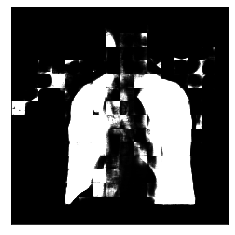

In [4]:
file = "MCUCXR_0251_1.png"
img = cv2.imread(os.path.join(img_dir, file), 0)

plt.imshow(img, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

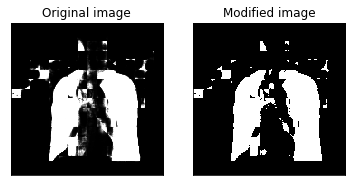

In [5]:
img2 = np.copy(img)
bg = np.where(img2[:,:] < 100)
fg = np.where(img2[:,:] >= 100)

img2[bg] = 0
img2[fg] = 255

plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.title('Original image')

plt.subplot(1,2,2)
plt.imshow(img2, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.title('Modified image')
plt.show()
      

In [6]:
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img2, connectivity=8)
sizes = stats[1:, -1]
nb_components = nb_components - 1

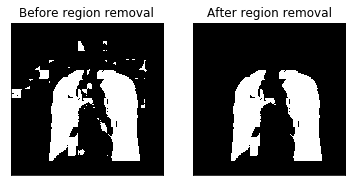

In [7]:
max_size = 5000
img3 = np.copy(img2)
#for every component in the image, you keep it only if it's above min_size
for i in range(0, nb_components):
    if sizes[i] <= max_size:
        img3[output == i + 1] = 0
        
plt.subplot(1,2,1)
plt.imshow(img2, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.title('Before region removal')

plt.subplot(1,2,2)
plt.imshow(img3, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.title('After region removal')
plt.show()

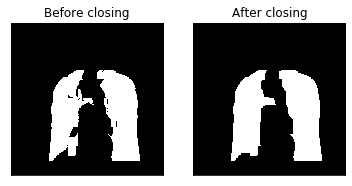

In [8]:
kernel = np.ones((55,55), np.uint8)
closing = cv2.morphologyEx(img3, cv2.MORPH_CLOSE, kernel)

plt.subplot(121),plt.imshow(img3, cmap='gray'),plt.title('Before closing')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(closing, cmap='gray'),plt.title('After closing')
plt.xticks([]), plt.yticks([])
plt.show()

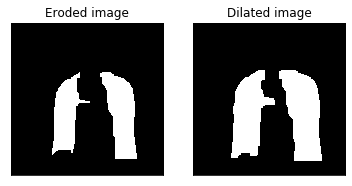

In [9]:
kernel1 = np.ones((35,35), np.uint8)
#kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))

eroded_img = cv2.erode(closing, kernel1, iterations=1)

kernel2 = np.ones((35,35), np.uint8)
dilated_img = cv2.dilate(eroded_img, kernel2, iterations=1)

plt.subplot(1,2,1)
plt.imshow(eroded_img, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.title('Eroded image')

plt.subplot(1,2,2)
plt.imshow(dilated_img, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.title('Dilated image')
plt.show()

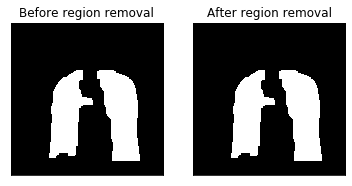

In [10]:
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(dilated_img, connectivity=8)
sizes = stats[1:, -1]
nb_components = nb_components - 1

max_size = 3000
rr_img = np.copy(dilated_img)
#for every component in the image, you keep it only if it's above min_size
for i in range(0, nb_components):
    if sizes[i] <= max_size:
        rr_img[output == i + 1] = 0
        
plt.subplot(1,2,1)
plt.imshow(dilated_img, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.title('Before region removal')

plt.subplot(1,2,2)
plt.imshow(rr_img, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.title('After region removal')
plt.show()

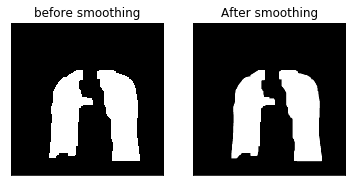

In [11]:
kernel = np.ones((5,5),np.float32)/25
smooth_img = cv2.filter2D(rr_img,-1,kernel)

plt.subplot(121),plt.imshow(rr_img, cmap='gray'),plt.title('before smoothing')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(smooth_img, cmap='gray'),plt.title('After smoothing')
plt.xticks([]), plt.yticks([])
plt.show()

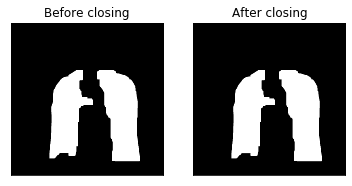

In [12]:
kernel = np.ones((55,55), np.uint8)
closing = cv2.morphologyEx(smooth_img, cv2.MORPH_CLOSE, kernel)

plt.subplot(121),plt.imshow(smooth_img, cmap='gray'),plt.title('Before closing')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(closing, cmap='gray'),plt.title('After closing')
plt.xticks([]), plt.yticks([])
plt.show()

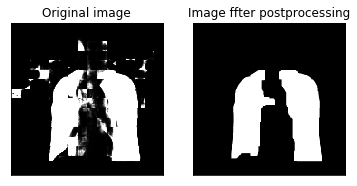

In [13]:
plt.subplot(121),plt.imshow(img, cmap='gray'),plt.title('Original image')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(closing, cmap='gray'),plt.title('Image ffter postprocessing')
plt.xticks([]), plt.yticks([])
plt.show()